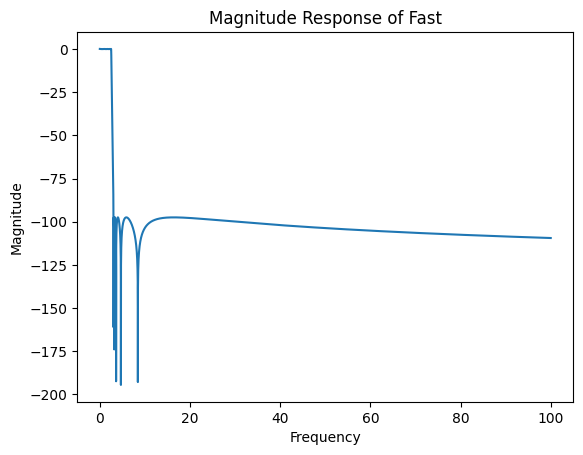

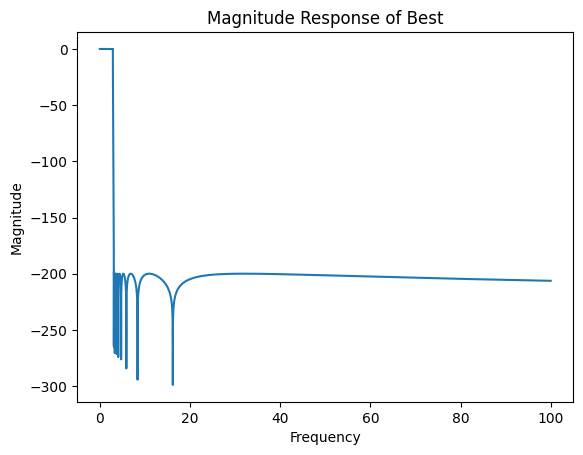

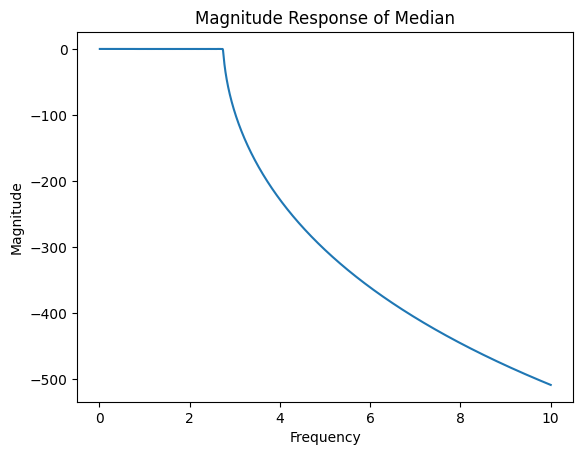

In [6]:
import numpy
import numpy as np
import scipy
import scipy.signal
import scipy.optimize
import sys
import matplotlib.pyplot as plt

def DesignElliptic(fpass, fstop, rpass, rstop, name):
	# 滤波器设计
	order, wn = scipy.signal.ellipord(fpass, fstop, rpass, rstop, True)
	b, a = scipy.signal.ellip(order, rpass, rstop, wn, analog=True)
	w, mag, phase = scipy.signal.bode(scipy.signal.TransferFunction(b, a), n=32768*16)
	
	idx = numpy.where(mag < -rstop)[0][0]
	# 实际上应该用elliptic-degree求精准k值?
	fstop = w[idx]

	# 转并行滤波器
	residue_coeffs, residue_poles, residue_direct = scipy.signal.residue(b, a)
	if len(residue_direct) > 0:
		raise RuntimeError(f'无法处理滤波器系数,拥有非一阶滤波器残差 {residue_direct}')
	
	plt.plot(w, mag)
	plt.xlabel('Frequency')
	plt.ylabel('Magnitude')
	plt.title(f'Magnitude Response of {name}')
	plt.show()

	# 导出系数
	real_indices = numpy.where(numpy.abs(residue_poles.imag) < 1e-6)
	real_poles = residue_poles[real_indices]
	complex_indices = numpy.where(residue_poles.imag >= 1e-6)
	complex_poles = residue_poles[complex_indices]

	# Calculate the coefficients for direct synthesis of the output
	real_coeffs_direct = residue_coeffs[real_indices]*1
	complex_coeffs_direct = residue_coeffs[complex_indices]*2 # doubled since we're only using one and taking the real part

	return (fpass, fstop, order, real_coeffs_direct, real_poles, complex_coeffs_direct, complex_poles, name)


def DesignChebyshev1(fpass, fstop, rpass, rstop, name):
	# 滤波器设计
	order, wn = scipy.signal.cheb1ord(fpass, fstop, rpass, rstop, True)
	# 阻止偶数阶切比雪夫1在DC处不为0
	if order % 2 == 0:
		order += 1
	b, a = scipy.signal.cheby1(order, rpass, wn, analog=True)
	w, mag, phase = scipy.signal.bode(scipy.signal.TransferFunction(b, a), n=32768*16)
	
	idx = numpy.where(mag < -rstop)[0][0]
	# 实际上应该用elliptic-degree求精准k值?
	fstop = w[idx]

	# 转并行滤波器
	residue_coeffs, residue_poles, residue_direct = scipy.signal.residue(b, a)
	if len(residue_direct) > 0:
		raise RuntimeError(f'无法处理滤波器系数,拥有非一阶滤波器残差 {residue_direct}')
	
	plt.plot(w, mag)
	plt.xlabel('Frequency')
	plt.ylabel('Magnitude')
	plt.title(f'Magnitude Response of {name}')
	plt.show()
	
	# 导出系数
	real_indices = numpy.where(numpy.abs(residue_poles.imag) < 1e-6)
	real_poles = residue_poles[real_indices]
	complex_indices = numpy.where(residue_poles.imag >= 1e-6)
	complex_poles = residue_poles[complex_indices]

	# Calculate the coefficients for direct synthesis of the output
	real_coeffs_direct = residue_coeffs[real_indices]*1
	complex_coeffs_direct = residue_coeffs[complex_indices]*2 # doubled since we're only using one and taking the real part

	return (fpass, fstop, order, real_coeffs_direct, real_poles, complex_coeffs_direct, complex_poles, name)

t = []
# t.append(DesignElliptic(20000, 25000, 0.1, 97.5, 'Fast'))
t.append(DesignElliptic(20000 * np.pi / 25000, np.pi, 0.1, 97.5, 'Fast'))
# t.append(DesignElliptic(20000, 21700, 0.1, 200, 'Best'))
t.append(DesignElliptic(20000 * np.pi / 21700, np.pi, 0.1, 200, 'Best'))
# t.append(DesignChebyshev1(20000, 23000, 0.1, 120, 'Median'))
t.append(DesignChebyshev1(20000 * np.pi / 23000, np.pi, 0.1, 120, 'Median'))

output_code ='''#pragma once
#include <array>
#include <complex>

namespace qwqdsp_fx::coeff{'''
for (fpass, fstop, order, real_coeffs, real_poles, complex_coeffs, complex_poles, name) in t:
	cppCode = """
template<typename Sample>
struct %sCoeffs {
	using TSample = Sample;
	static constexpr size_t complexCount = %i;
	static constexpr size_t realCount = %i;
	static constexpr size_t filterOrder = %i;
	static constexpr Sample fpass = Sample(%f);
	static constexpr Sample fstop = Sample(%f);
	static constexpr std::array<std::complex<Sample>, complexCount> complexPoles{{
		%s
	}};
	static constexpr std::array<Sample, realCount> realPoles{{
		%s
	}};
	// Coeffs for direct bandlimited synthesis of a polynomial-segment waveform
	static constexpr std::array<std::complex<Sample>, complexCount> complexCoeffsDirect{{
		%s
	}};
	static constexpr std::array<Sample, realCount> realCoeffsDirect{{
		%s
	}};
};
	"""%(
		name,
		len(complex_poles),
		len(real_poles),
		order,
		fpass,
		fstop,
		",\n\t\t".join(["{Sample(%s), Sample(%s)}"%(p.real.astype(str), p.imag.astype(str)) for p in complex_poles]),
		",\n\t\t".join(["Sample(%s)"%(p.real.astype(str)) for p in real_poles]),
		",\n\t\t".join(["{Sample(%s), Sample(%s)}"%(p.real.astype(str), p.imag.astype(str)) for p in complex_coeffs]),
		",\n\t\t".join(["Sample(%s)"%(p.real.astype(str)) for p in real_coeffs]),
	)
	output_code += cppCode


output_code += "}\n"

with open("resample_coeffs.h", 'w') as file:
	file.write(output_code)
